# GEONE - GEOSCLASSIC - Examples in 3D

## Estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS)

See notebook `ex_geosclassic_1d_1.ipynb` for detail explanations about estimation (kriging) and simulation (Sequential Gaussian Simulation, SGS) in a grid.

## Examples in 3D
In this notebook, examples in 3D with a stationary covariance model are given.

*Remark: for examples with non-stationary covariance models in 3D, see jupyter notebook `ex_geosclassic_3d_2_non_stat_cov.ipynb`.*




## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
import scipy
import time

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=13, micro=7, releaselevel='final', serial=0)
geone version: 1.3.0


In [3]:
pv.set_jupyter_backend('static') # static plots
# pv.set_jupyter_backend('trame')  # 3D-interactive plots

### Remark
The matplotlib figures can be visualized in *interactive* mode:

- `%matplotlib notebook`: enable interactive mode
- `%matplotlib inline`: disable interactive mode

## Grid (3D)

In [4]:
nx, ny, nz = 85, 56, 34  # number of cells
sx, sy, sz = 1.0, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

dimension = (nx, ny, nz)
spacing = (sx, sy, sz)
origin = (ox, oy, oz)

## Covariance model

In 3D, a covariance model is given by an instance of the class `geone.covModel.covModel3D` (or `geone.covModel.covModel1D` for omni-directional (isotropic) case).

A covariance model is defined by its elementary contributions given as a list of 2-tuples, 
whose the first component is the type given by a string (`nugget`, `spherical`, `exponential`, `gaussian`, ...) and the second component is a dictionary used to pass the required parameters (the weight (`w`), the range (`r`), ...).

Azimuth (`alpha`), dip (`beta`) and plunge (`gamma`) angles can be specified in degrees: the coordinates system Ox'''y''''z''', supporting the axes of the model (ranges), is obtained from the original coordinates system Oxyz as follows:

- Oxyz       -> rotation of angle -alpha around Oz   -> Ox'y'z'
- Ox'y'z'    -> rotation of angle -beta  around Ox'  -> Ox''y''z''
- Ox''y''z'' -> rotation of angle -gamma around Oy'' -> Ox'''y'''z'''

*Note: see the notebook `ex_general_multiGaussian.ipynb` for available covariance models and examples.*

In [5]:
cov_model = gn.covModel.CovModel3D(elem=[
    ('gaussian', {'w':8.5, 'r':[40, 20, 10]}), # elementary contribution
    ('nugget', {'w':0.5})                      # elementary contribution
    ], alpha=-30, beta=-40, gamma=20, name='model-3D example')

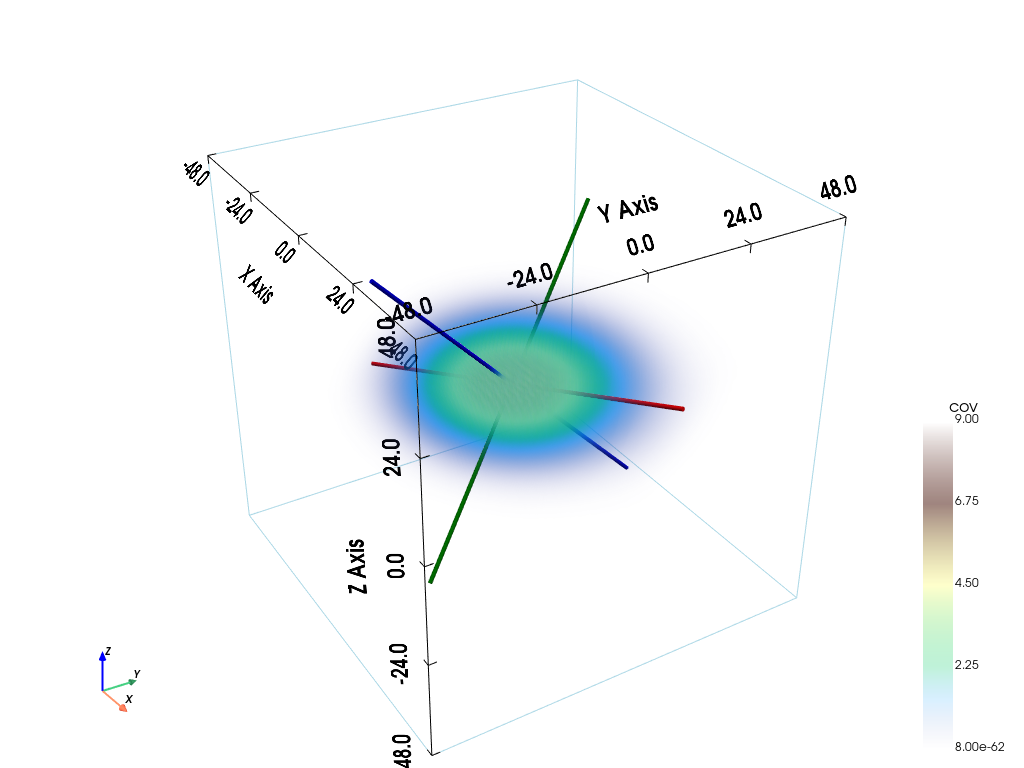

In [6]:
pp = pv.Plotter()
# pp = pv.Plotter(notebook=False) # open a plotter and specifying 'notebook=False'
cov_model.plot_model3d_volume(plotter=pp)
cpos = pp.show(cpos=(165, -100, 115), return_cpos=True)

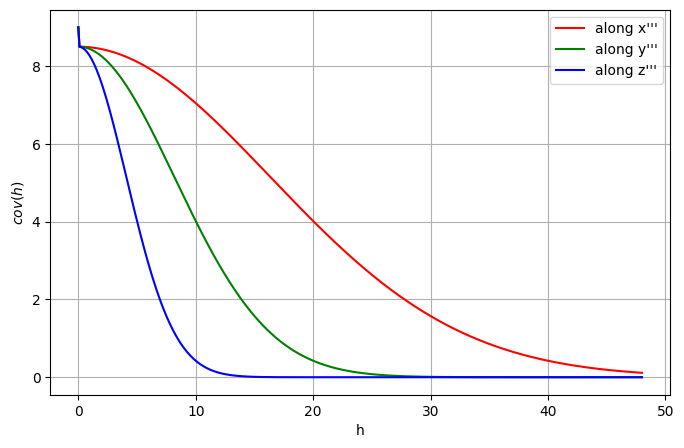

In [7]:
plt.figure(figsize=(8, 5))
cov_model.plot_model_curves()
plt.show()

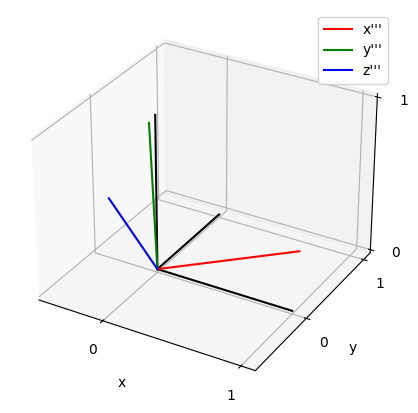

In [8]:
cov_model.plot_mrot(figsize=(5,5))

## 1. Example - Set-up

In [9]:
# Data
x = np.array([[ 10.25,  20.14,  3.15], 
              [ 40.50,  10.50, 10.50], 
              [ 30.65,  40.53, 20.24],
              [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
v_err_std = 0.0                  # data error standard deviation
# v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 10.25,  10.35,  6.51],
                   [ 50.15,  20.35, 20.50],
                   [ 65.50,   5.50,  3.50]]) # locations (real coordinates)
v_ineq_min = [    4., -2.3, np.nan]  # lower bounds
v_ineq_max = [np.nan, -1.7,   -4.1]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Type of kriging
method = 'simple_kriging'

### Estimation (kriging)

In [10]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            method=method,                 # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (6246 times in all):
#  1: WARNING 02015

In [11]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(6246, ['WARNING 02015: solving kriging system fails (do as if no neighbor)'])

### Simulations

In [12]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method=method,                 # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (50 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 24...
_run_krige_an

In [13]:
# Total number of warning(s), and warning messages
geosclassic_output['nwarning'], geosclassic_output['warnings']

(0, [])

### Plot the results

In [14]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')


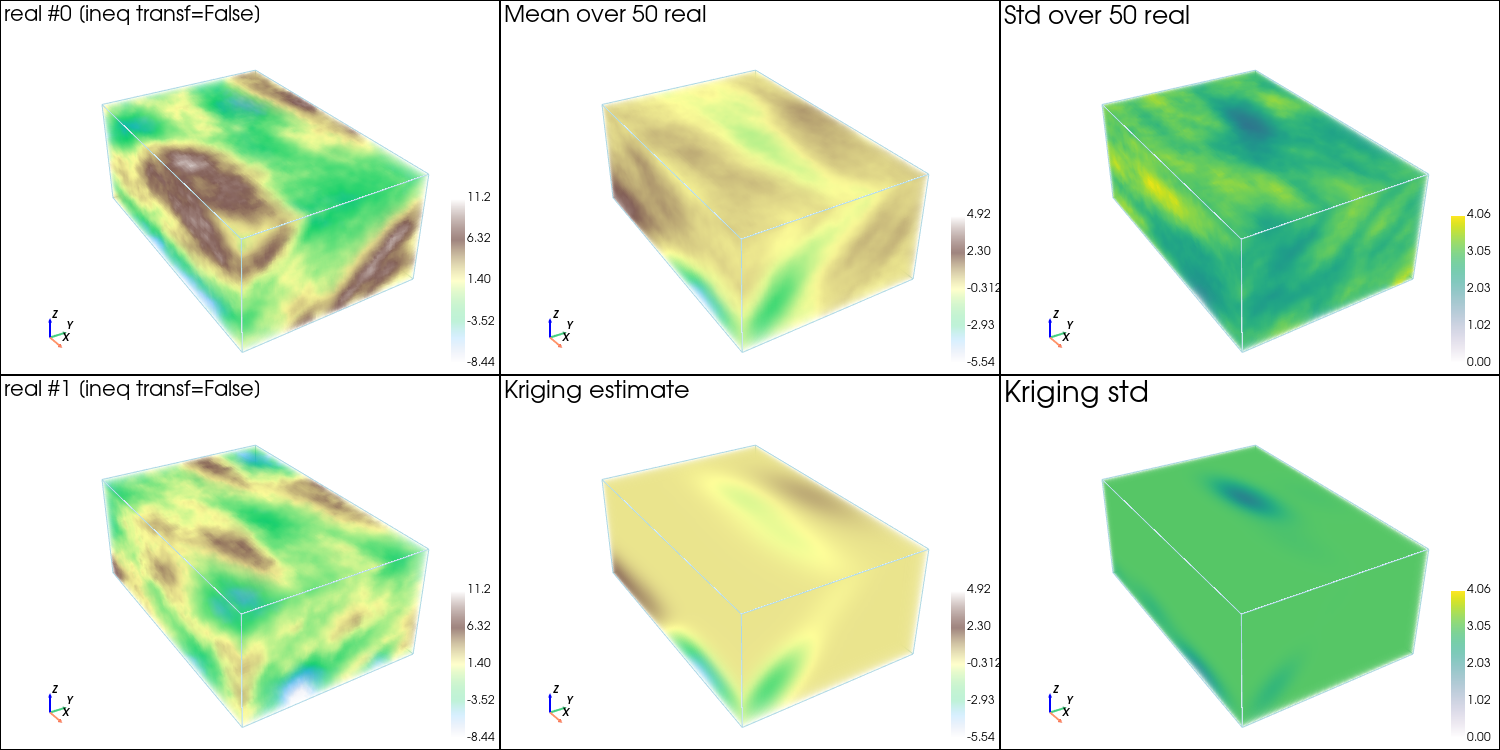

In [15]:
# Color settings
cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1]) # min value for std and kriging std
cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1]) # max value for std and kriging std

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_img_mean, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    simul_img_std, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

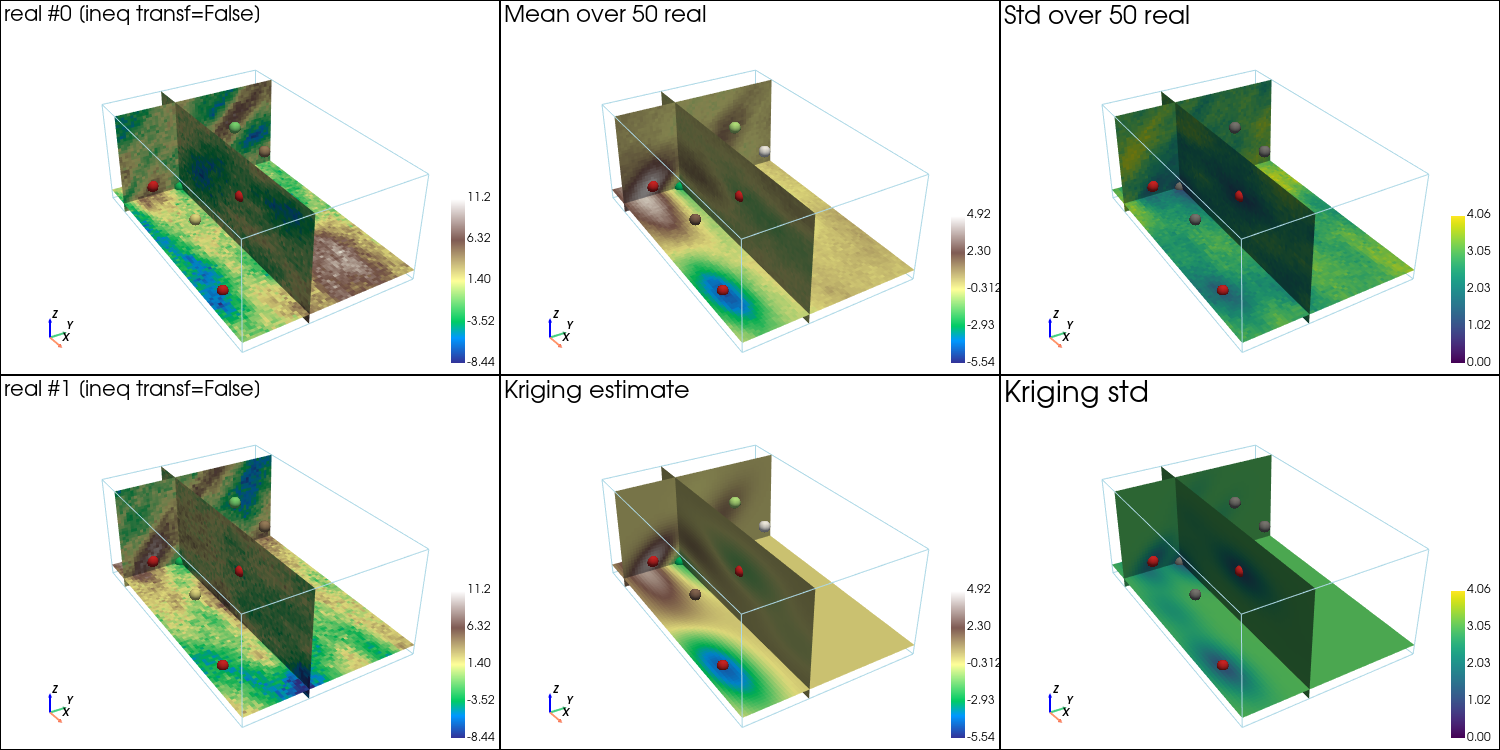

In [16]:
# Plot slices (with data points)
# ------------------------------
# # Color settings
# cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
# cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

# cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
# cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

# cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1]) # min value for std and kriging std
# cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1]) # max value for std and kriging std

# cmap = 'terrain'
# cmap_mean = 'terrain'
# cmap_std = 'viridis'

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.2*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

if x_ineq is not None:
    # Set points to be plotted
    ineq_data_points = pv.PolyData(x_ineq)
    col_ineq = 'tab:red'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
    if x_ineq is not None:
        pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_img_mean, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    simul_img_std, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Detailed results around data points

In [17]:
# Get data error std (array)
data_err_std = np.atleast_1d(v_err_std)
if data_err_std.size==1:
    data_err_std = np.ones_like(v)*data_err_std[0]

# Get index of conditioning location in the grid
data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in data_grid_index])

print('Data location:\n', x)
print('Data cell center loc.:\n', x_center)
print('Is close to cell center ?\n', np.isclose(x, x_center).all(axis=1))


Data location:
 [[10.25 20.14  3.15]
 [40.5  10.5  10.5 ]
 [30.65 40.53 20.24]
 [30.18 30.14 30.98]]
Data cell center loc.:
 [[10.5 20.5  3.5]
 [40.5 10.5 10.5]
 [30.5 40.5 20.5]
 [30.5 30.5 30.5]]
Is close to cell center ?
 [False  True False False]


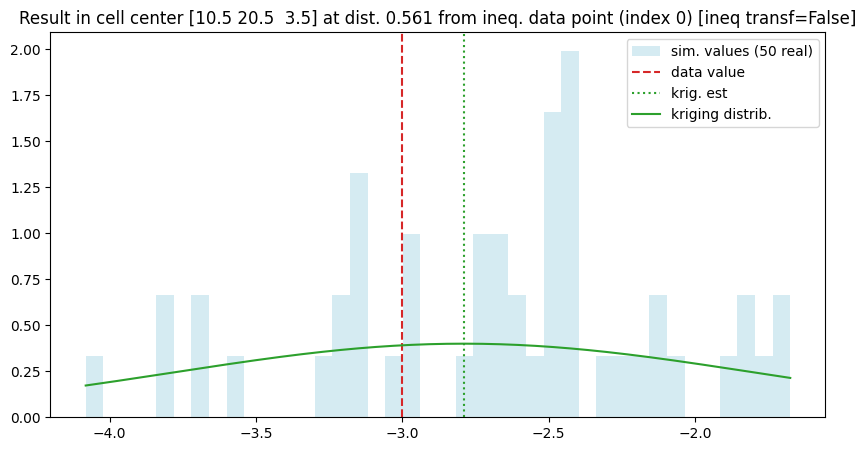

In [18]:
# Show results around one data point
# ----------------------------------
# Choose data index
j = 0

d = np.sqrt(np.sum((x[j] - x_center[j])**2))        # distance from cell center to data location
ix, iy, iz = data_grid_index[j]                     # grid index of cell containing the data point
sim_v = simul_img.val[:, iz, iy, ix]                # simulated values at cell center
krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix] # kriging estimate and std at cell center

t = np.linspace(sim_v.min(), sim_v.max(), 200)

# Plot
plt.figure(figsize=(10, 5))

plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
plt.axvline(v[j], c='tab:red', ls='dashed', label='data value')

if data_err_std[j] > 0:
    plt.plot(t, scipy.stats.norm(loc=v[j], scale=data_err_std[j]).pdf(t), c='tab:red', ls='solid', label='data distrib. (acc. for err.)')

plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
if krig_v_std > 0:
    plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

plt.legend()
plt.title(f'Result in cell center {x_center[j]} at dist. {d:.3g} from ineq. data point (index {j}) [ineq transf={mode_transform_ineq_to_data}]')
plt.show()


### Detailed results around inequality data points

In [19]:
# Get index of conditioning location in the grid
ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sz, ox, oy, oz) for xk in x_ineq] # (ix, iy, iz) for each data point
# Coordinate of cell center containing the inequality data points
x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])

print('Inequality location:\n', x_ineq)
print('Inequality cell center loc.:\n', x_ineq_center)
print('Is close to cell center ?\n', np.isclose(x_ineq, x_ineq_center).all(axis=1))


Inequality location:
 [[10.25 10.35  6.51]
 [50.15 20.35 20.5 ]
 [65.5   5.5   3.5 ]]
Inequality cell center loc.:
 [[10.5 10.5  6.5]
 [50.5 20.5 20.5]
 [65.5  5.5  3.5]]
Is close to cell center ?
 [False False  True]


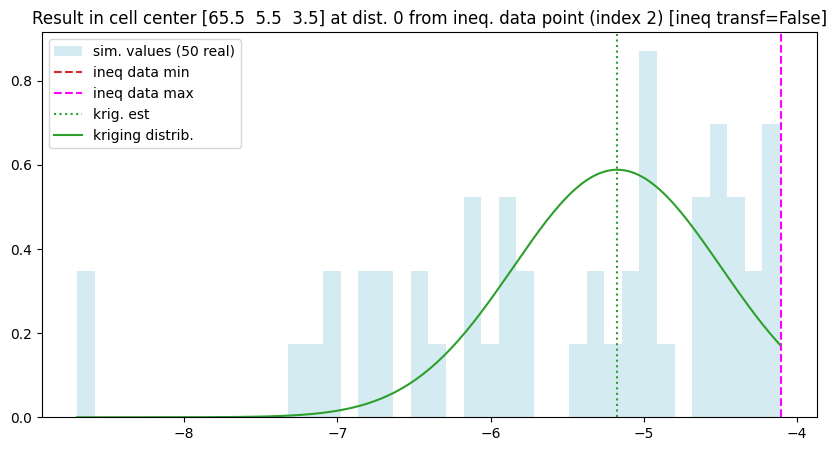

In [20]:
# Show results around an inequality data point
# --------------------------------------------
# Choose inequality data index
j = 2

d = np.sqrt(np.sum((x_ineq[j] - x_ineq_center[j])**2)) # distance from cell center to inequality data location
ix, iy, iz = ineq_data_grid_index[j]                   # grid index of cell containing the inequality data point
sim_v = simul_img.val[:, iz, iy, ix]                   # simulated values at cell center
krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]    # kriging estimate and std at cell center

t = np.linspace(sim_v.min(), sim_v.max(), 200)

# Plot
plt.figure(figsize=(10, 5))

plt.hist(sim_v, bins=40, density=True, color='lightblue', alpha=0.5, label=f'sim. values ({nreal} real)')
plt.axvline(v_ineq_min[j], c='tab:red', ls='dashed', label='ineq data min') # not necessarily present (could be nan)
plt.axvline(v_ineq_max[j], c='magenta', ls='dashed', label='ineq data max') # not necessarily present (could be nan)

plt.axvline(krig_v_mu, c='tab:green', ls='dotted', label='krig. est')
if krig_v_std > 0:
    plt.plot(t, scipy.stats.norm(loc=krig_v_mu, scale=krig_v_std).pdf(t), c='tab:green', ls='solid', label='kriging distrib.')

plt.legend()
plt.title(f'Result in cell center {x_ineq_center[j]} at dist. {d:.3g} from ineq. data point (index {j}) [ineq transf={mode_transform_ineq_to_data}]')
plt.show()


### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [21]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                        = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [transform=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [transform={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.5609
   data value                        = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = -2.790e+00 [krig. std = 9.968e-01]
   simul. [transform=False]   : mean = -2.687e+00, min = -4.082e+00, max = -1.675e+00 [std = 5.727e-01]
Data point index 1, dist. to cell center = 0
   data value                        = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 2.000e+00 [krig. std = 0.000e+00]
   simul. [transform=False]   : mean = 2.000e+00, min = 2.000e+00, max = 2.000e+00 [std = 7.022e-17]
Data point index 2, dist. to cell center = 0.3017
   data value                        = 5.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 4.719e+00 [krig. std = 9.990e-01]
   simul. [transform=False]   : mean = 4.349e+00, min = 3.154e+00, max = 5.484e+00 [std = 5.696e-01]
Data point index 3, dist. to cell center = 0.68
   data value                        = -1.000e

In [22]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [transform=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [transform=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.2917
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
Ineq. data point index 1, dist. to cell center = 0.3808
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 52.000%
Ineq. data point index 2, dist. to cell center = 0
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 100.000%


## 2. Example with imposed mean and/or variance (simple kriging only)
Mean and variance in the simulation grid can be specified if simple kriging is used, they can be stationary (constant) or non-stationary. By default, the mean is set to the mean of data values (or zero if no conditioning data) (constant) and the variance is given by the sill of the variogram model (constant).


### 2.1 Constant mean and variance
Set mean to $5.0$ and variance to the double of the covariance model sill. No inequality is considered in this example.

In [23]:
# Data
x = np.array([[ 10.25,  20.14,  3.15], 
              [ 40.50,  10.50, 10.50], 
              [ 30.65,  40.53, 20.24],
              [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
v_err_std = 0.0                  # data error standard deviation
# v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 10.25,  10.35,  6.51],
                   [ 50.15,  20.35, 20.50],
                   [ 65.50,   5.50,  3.50]]) # locations (real coordinates)
v_ineq_min = [    4., -2.3, np.nan]  # lower bounds
v_ineq_max = [np.nan, -1.7,   -4.1]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Specify mean and variance
mean = 5.0
var = 2.0 * cov_model.sill()

### Estimation (kriging)

In [24]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean,                     # mean
                            var=var,                       # variance
                            method='simple_kriging',       # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (6573 times in all):
#  1: WARNING 02015

### Simulations

In [25]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean,                     # mean
                            var=var,                       # variance
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (50 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 24...
_run_krige_an

### Plot the results

In [26]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')


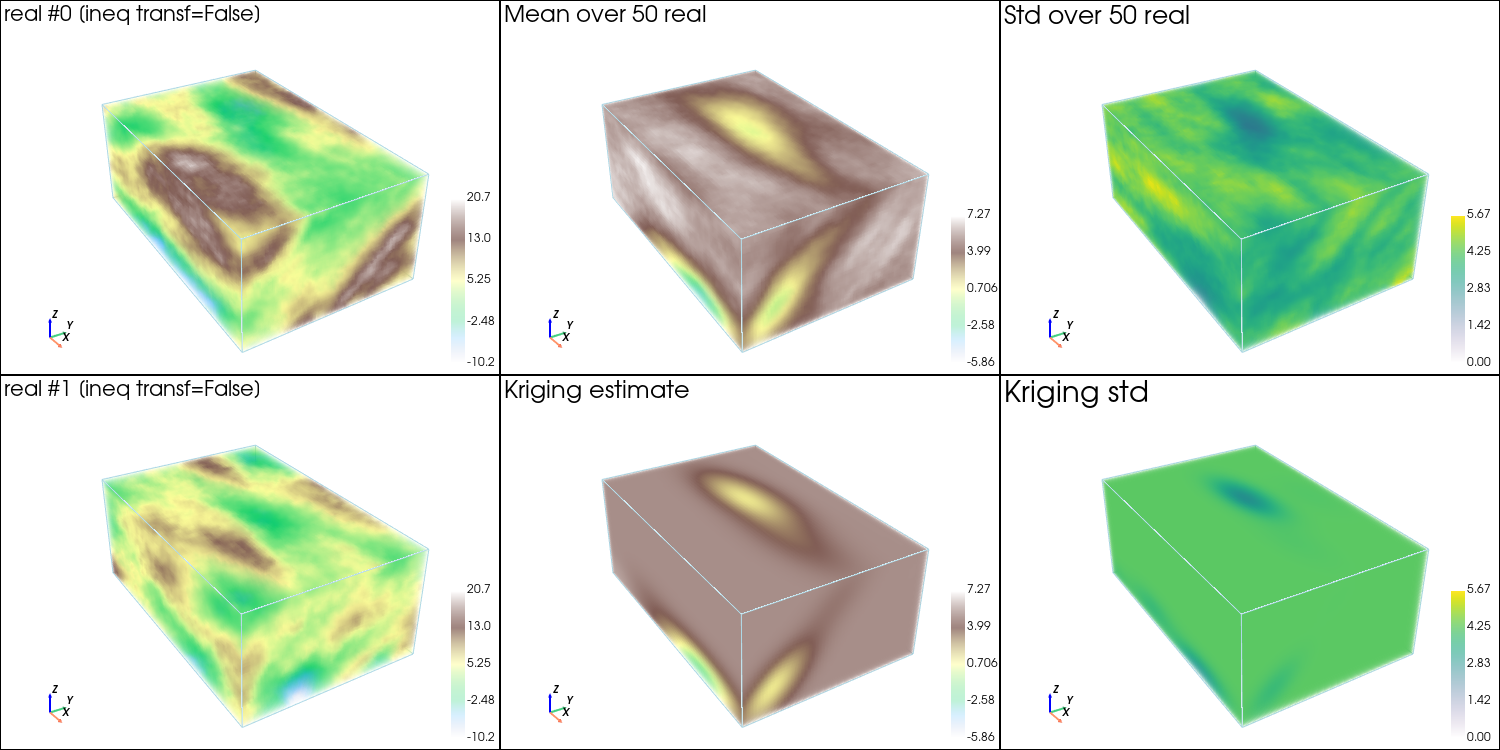

In [27]:
# Color settings
cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1]) # min value for std and kriging std
cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1]) # max value for std and kriging std

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2, 3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_img_mean, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    simul_img_std, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

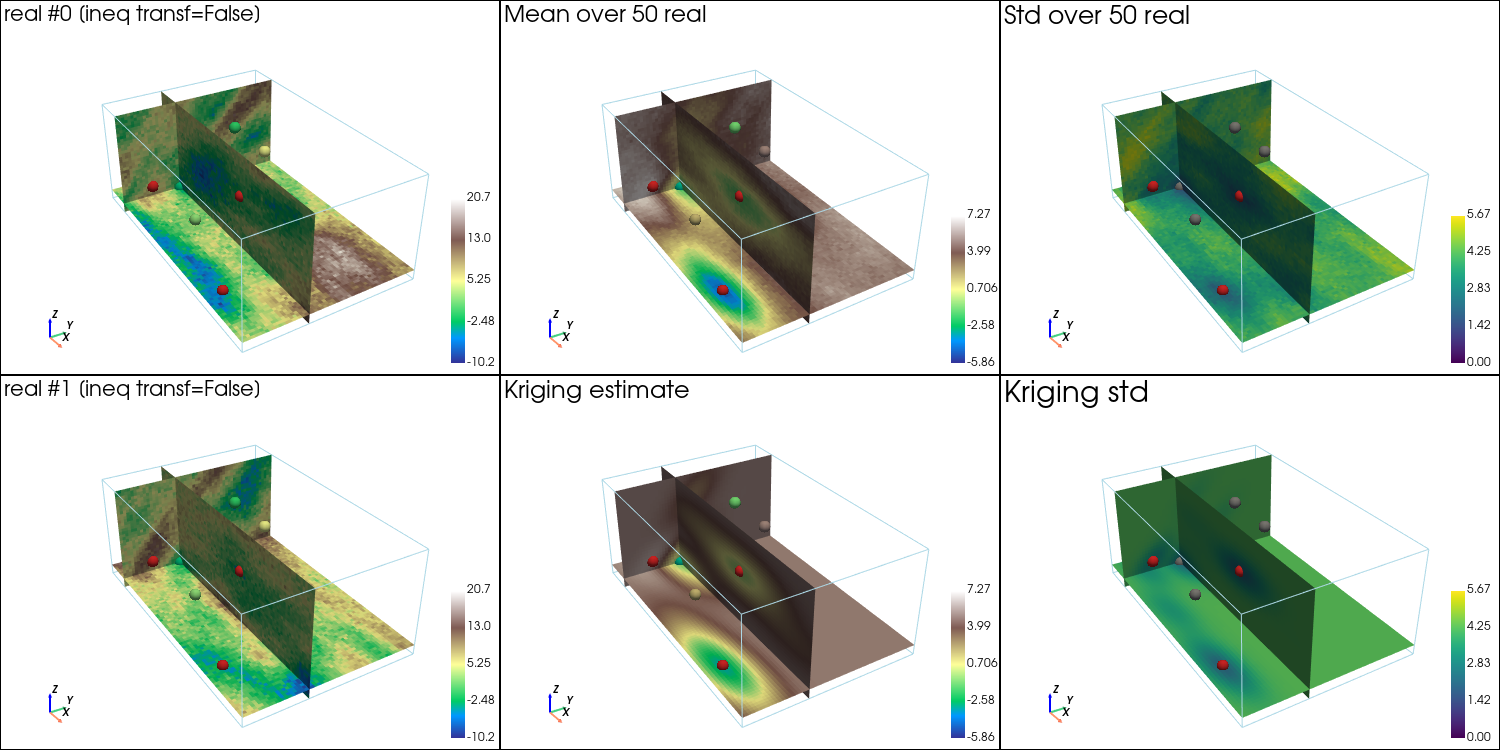

In [28]:
# Plot slices (with data points)
# ------------------------------
# # Color settings
# cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
# cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

# cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0]) # min value for mean and kriging estimate
# cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0]) # max value for mean and kriging estimate

# cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1]) # min value for std and kriging std
# cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1]) # max value for std and kriging std

# cmap = 'terrain'
# cmap_mean = 'terrain'
# cmap_std = 'viridis'

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.2*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

if x_ineq is not None:
    # Set points to be plotted
    ineq_data_points = pv.PolyData(x_ineq)
    col_ineq = 'tab:red'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,3), window_size=(1500, 750), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,3), window_size=(1500, 750))

# 2 first reals
for i in (0, 1):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
    if x_ineq is not None:
        pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_img_mean, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':2*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    simul_img_std, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [29]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                        = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [transform=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [transform={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.5609
   data value                        = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = -2.540e+00 [krig. std = 1.410e+00]
   simul. [transform=False]   : mean = -1.874e+00, min = -4.578e+00, max = 8.789e-02 [std = 1.122e+00]
Data point index 1, dist. to cell center = 0
   data value                        = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 2.000e+00 [krig. std = 0.000e+00]
   simul. [transform=False]   : mean = 2.000e+00, min = 2.000e+00, max = 2.000e+00 [std = 0.000e+00]
Data point index 2, dist. to cell center = 0.3017
   data value                        = 5.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 4.992e+00 [krig. std = 1.413e+00]
   simul. [transform=False]   : mean = 4.734e+00, min = 2.418e+00, max = 6.940e+00 [std = 1.110e+00]
Data point index 3, dist. to cell center = 0.68
   data value                        = -1.000e+

In [30]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [transform=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [transform=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.2917
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 84.000%
Ineq. data point index 1, dist. to cell center = 0.3808
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
   does kriging mean value respect ineq data max [transform=True] : False
   percentage of simul. respecting ineq data max [transform=False]: 38.000%
Ineq. data point index 2, dist. to cell center = 0
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 100.000%


### 2.2 Non-stationary mean and variance
Set a varying mean and a varying variance over the simulation domain.

In [31]:
# Data
x = np.array([[ 10.25,  20.14,  3.15], 
              [ 40.50,  10.50, 10.50], 
              [ 30.65,  40.53, 20.24],
              [ 30.18,  30.14, 30.98]]) # data locations (real coordinates)
v = [ -3.,  2.,   5.,  -1.]  # data values
v_err_std = 0.0                  # data error standard deviation
# v_err_std = [0.0, 0.0, 0.3, 1.0] # data error standard deviation
                                   #   float: same for all data points
                                   #   list or array: per data point

# Inequality data
x_ineq = np.array([[ 10.25,  10.35,  6.51],
                   [ 50.15,  20.35, 20.50],
                   [ 65.50,   5.50,  3.50]]) # locations (real coordinates)
v_ineq_min = [    4., -2.3, np.nan]  # lower bounds
v_ineq_max = [np.nan, -1.7,   -4.1]  # upper bounds
# x_ineq = None
# v_ineq_min = None
# v_ineq_max = None

# Specify mean and variance
# - set mean as a function that take three parameters (x, y, z location) and returns a value
def mean_fun(x, y, z):
    return 0.1*(z + y - x)

# - set variance as a function that take three parameters (x, y, z location) and returns a value
def var_fun(x, y, z):
    return 1 + 0.1*(x + y + z)

# Note:
# ----
# In function `gn.geosclassicinterface.estimate` and `gn.geosclassicinterface.simulate`, 
# the parameters `mean` and `var` can also be array of values in the grid

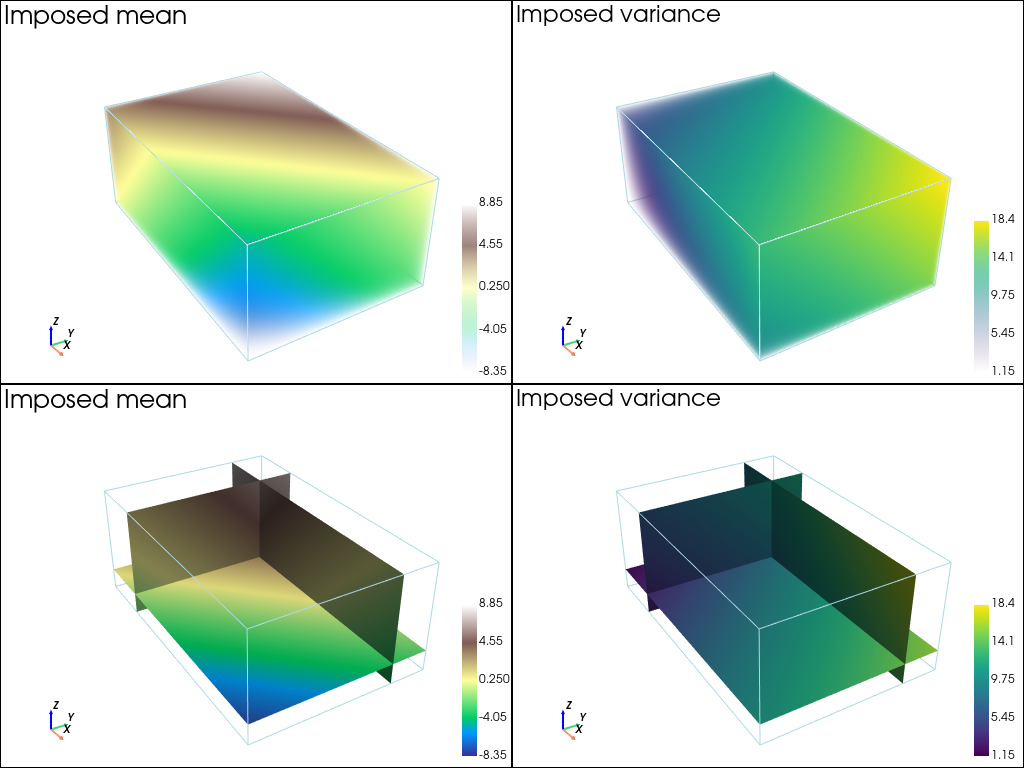

In [32]:
# Plot mean and var
# -----------------
# Set an image with grid geometry defined above, and no variable
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=0)

# Get the x and y coordinates of the centers of grid cell (meshgrid)
xx = im.xx()
yy = im.yy()
zz = im.zz()

# # Equivalent:
# ## xg, yg, zg: coordinates of the centers of grid cell
# xg = ox + sx*(0.5+np.arange(nx))
# yg = oy + sy*(0.5+np.arange(ny))
# zg = oz + sz*(0.5+np.arange(nz))
# zz, yy, xx = np.meshgrid(zg, yg, xg, indexing='ij')

# Define the mean and variance on the grid
mean = mean_fun(xx, yy, zz)
var = var_fun(xx, yy, zz)
# Equivalent: use the expression of the functions above
# mean = 0.1*(zz + yy - xx) 
# var = 1 + 0.1*(xx + yy + zz)

# Set variable mean and var in image im
im.append_var([mean, var], varname=['mean', 'var'])

# Display imposed mean and var
# Color settings
cmap = 'terrain'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2))

# mean (3d)
pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_volume(
    im, iv=0, 
    plotter=pp,
    cmap=cmap, 
    text='Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':0*' ', 'vertical':True, 'label_font_size':12})

# var
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    im, iv=1, 
    plotter=pp,
    cmap='viridis', 
    text='Imposed variance',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':1*' ', 'vertical':True, 'label_font_size':12})

# Set slices
slice_normal_x = im.x()[int(0.2*nx)]
slice_normal_y = im.y()[int(0.8*ny)]
slice_normal_z = im.z()[int(0.2*nz)]

# mean
pp.subplot(1, 0)
gn.imgplot3d.drawImage3D_slice(
    im, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap,
    text='Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# var
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    im, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap='viridis', 
    text='Imposed variance',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Estimation (kriging)

In [33]:
# Computational resources
nthreads = 8
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

# Seed (used for simulation at ineq. data points)
seed = 913

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.estimate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean_fun,                 # mean (or mean=mean)
                            var=var_fun,                   # variance (or var=var)
                            method='simple_kriging',       # type of kriging
                            use_unique_neighborhood=True,  # search neighborhood ...
                            searchRadius=None,             # ... used for simulation at ineq. data points
                            searchRadiusRelative=4.0, 
                            nneighborMax=12,
                            seed=seed,                     # seed (used for simulation at ineq. data points)
                            nthreads=nthreads,             # computational resources
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

krig_img = geosclassic_output['image'] # output image

estimate: Preprocessing data done: final number of data points : 4, inequality data points: 3
estimate: Computational resources: nthreads = 8, nproc_sgs_at_ineq = 8
estimate: (Step 1.1) Do sgs at inequality data points (100 simulation(s) at 3 points)...
estimate: (Step 1.2) Transform inequality data to equality data with error std...
estimate: (Step 2) Set new dataset gathering data and inequality data locations...
estimate: (Step 3) Do kriging at the center of grid cells containing at least one data point...
estimate: (Step 4) Do kriging on the grid (at cell centers) using data points at cell centers...
estimate: Geos-Classic running on 1 process... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic running... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 8 thread(s)]
run_MPDSOMPGeosClassicSim: Geos-Classic run complete
estimate: Geos-Classic (1 process) run complete
estimate: warnings encountered (6183 times in all):
#  1: WARNING 02015

### Simulations

In [34]:
# Number of realizations
nreal = 50

# Seed
seed = 321

# Simulation mode (in case where there is inequality data)
mode_transform_ineq_to_data = False # Transform ineq. to data with err ?

# Computational resources
nproc = 2
nthreads_per_proc = 4
nproc_sgs_at_ineq = None # default: nthreads (used for simulation at ineq. data points)

t1 = time.time() # start time
geosclassic_output = gn.geosclassicinterface.simulate(
                            cov_model,                     # covariance model (required)
                            dimension, spacing, origin,    # grid geometry (dimension is required)
                            x=x, v=v, v_err_std=v_err_std, # data 
                            x_ineq=x_ineq,                 # inequality data ...
                            v_ineq_min=v_ineq_min, 
                            v_ineq_max=v_ineq_max, 
                            mean=mean_fun,                 # mean (or mean=mean)
                            var=var_fun,                   # variance (or var=var)
                            mode_transform_ineq_to_data=mode_transform_ineq_to_data,
                            method='simple_kriging',       # type of kriging
                            searchRadius=None,             # search neighborhood ...
                            searchRadiusRelative=1.2, 
                            nneighborMax=12,
                            nreal=nreal,                   # number of realizations
                            seed=seed,                     # seed
                            nproc=nproc,                   # computational resources ...
                            nthreads_per_proc=nthreads_per_proc, 
                            nproc_sgs_at_ineq=nproc_sgs_at_ineq,
                            verbose=2                      # verbose mode
                        )
t2 = time.time() # end time
print('Elapsed time: {:.2g} sec'.format(t2-t1))

simul_img = geosclassic_output['image'] # output image


simulate: Preprocessing data done: final number of data points : 4, inequality data points: 3
simulate: Computational resources: nproc = 2, nthreads_per_proc = 4, nproc_sgs_at_ineq = 8
simulate: (Step 1.1) Do sgs at inequality data points (50 simulation(s) at 3 points)...
simulate: (Step 2-4): Krige + Geos-Classic running on 2 process(es)... [VERSION 2.1 / BUILD NUMBER 20251023 / OpenMP 4 thread(s)]
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     0 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     1 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     2 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     3 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     4 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     5 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     6 of 24...
_run_krige_and_MPDSOMPGeosClassicSim [pid=0]: realization     7 of 24...
_run_krige_an

### Plot the results

In [35]:
# Compute mean and standard deviation (pixel-wise)
simul_img_mean = gn.img.imageContStat(simul_img, op='mean')
simul_img_std  = gn.img.imageContStat(simul_img, op='std')


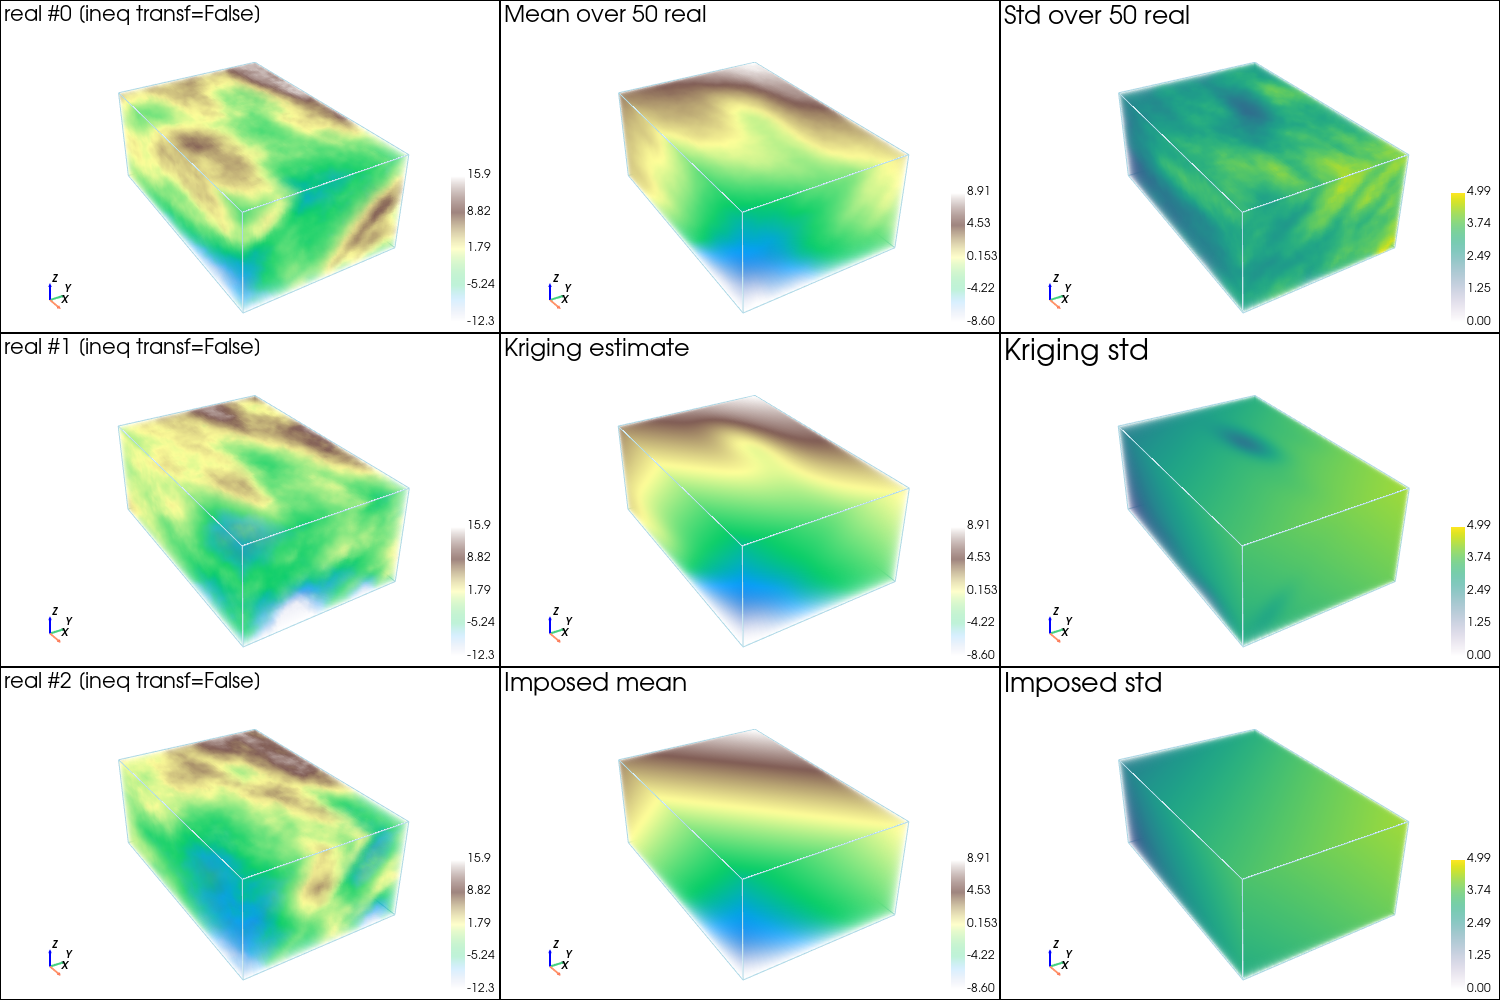

In [36]:
im_mean = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=im.val[0])
im_std = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=np.sqrt(im.val[1]))

# Color settings
cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0], im_mean.vmin()[0]) # min value for mean and kriging estimate and imposed mean
cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0], im_mean.vmax()[0]) # max value for mean and kriging estimate and imposed mean

cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1], im_std.vmin()[0]) # min value for std and kriging std and imposed mean
cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1], im_std.vmax()[0]) # max value for std and kriging std and imposed mean

cmap = 'terrain'
cmap_mean = 'terrain'
cmap_std = 'viridis'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000), notebook=False)
# ... inline
pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_volume(
        simul_img, iv=i, 
        plotter=pp,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_volume(
    simul_img_mean, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_volume(
    simul_img_std, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_volume(
    krig_img, iv=1, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':6*' ', 'vertical':True, 'label_font_size':12})

# Imposed mean
pp.subplot(2, 1)
gn.imgplot3d.drawImage3D_volume(
    im_mean, iv=0, 
    plotter=pp,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':7*' ', 'vertical':True, 'label_font_size':12})

# Imposed std
pp.subplot(2, 2)
gn.imgplot3d.drawImage3D_volume(
    im_std, iv=0, 
    plotter=pp,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Imposed std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':8*' ', 'vertical':True, 'label_font_size':12})

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

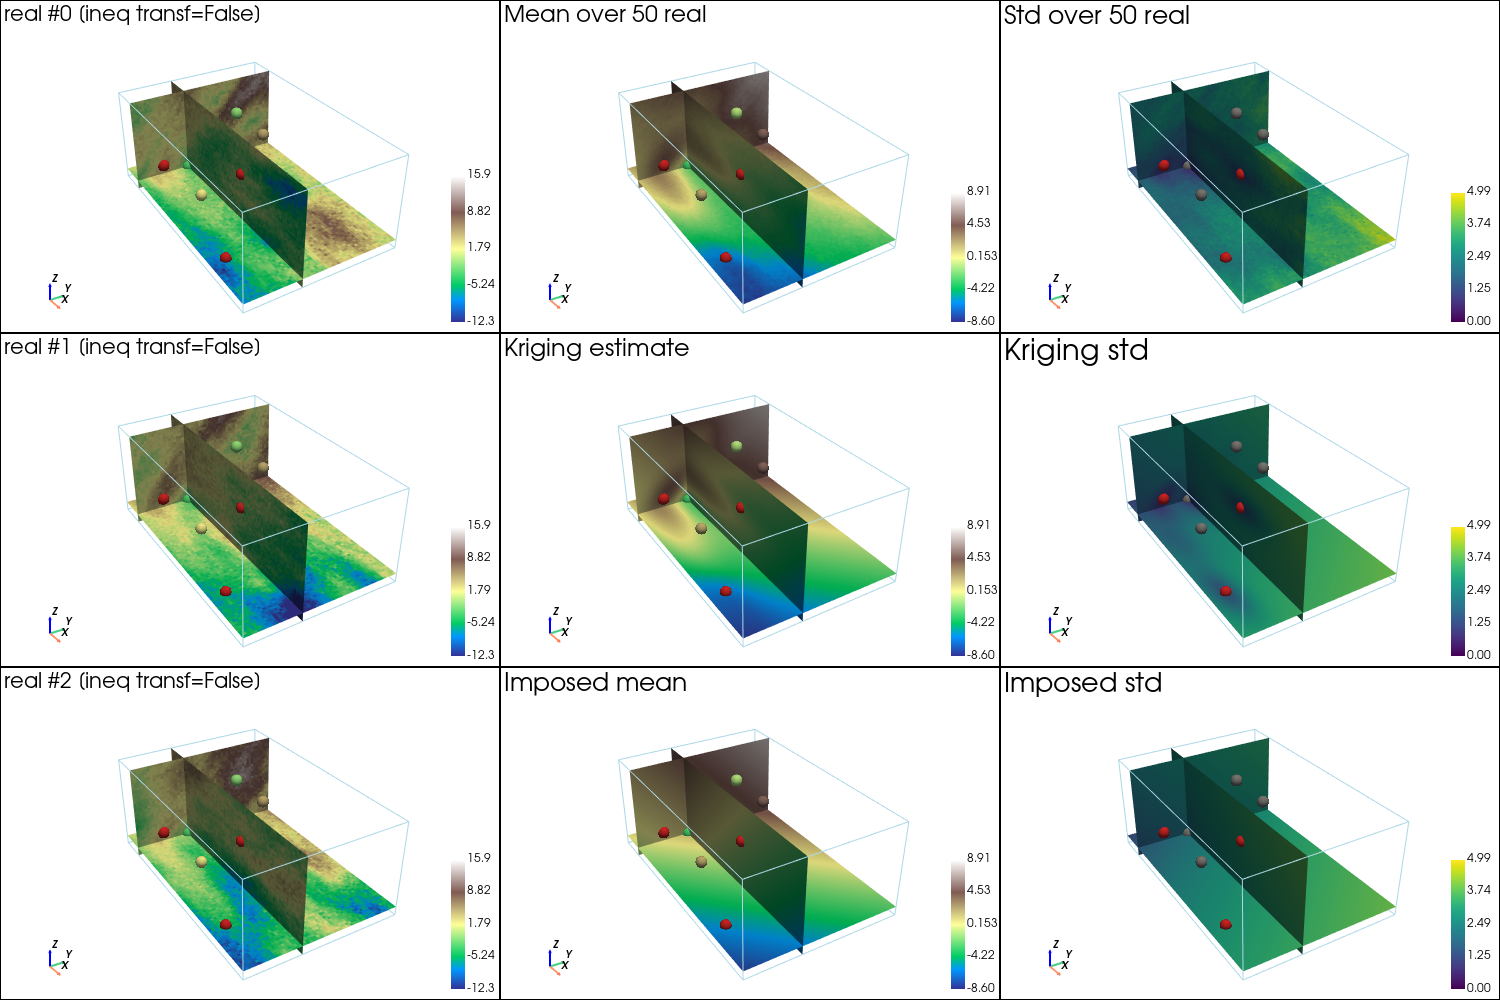

In [37]:
# Plot slices (with data points)
# ------------------------------
# cmin = np.min(simul_img.vmin()[0:1]) # min value for real 0 and 1
# cmax = np.max(simul_img.vmax()[0:1]) # max value for real 0 and 1

# cmin_mean = min(simul_img_mean.vmin()[0], krig_img.vmin()[0], im_mean.vmin()[0]) # min value for mean and kriging estimate and imposed mean
# cmax_mean = max(simul_img_mean.vmax()[0], krig_img.vmax()[0], im_mean.vmax()[0]) # max value for mean and kriging estimate and imposed mean

# cmin_std = min(simul_img_std.vmin()[0], krig_img.vmin()[1], im_std.vmin()[0]) # min value for std and kriging std and imposed mean
# cmax_std = max(simul_img_std.vmax()[0], krig_img.vmax()[1], im_std.vmax()[0]) # max value for std and kriging std and imposed mean

# cmap = 'terrain'
# cmap_mean = 'terrain'
# cmap_std = 'viridis'

# Settings for plotting data
if x is not None:
    # Get colors for conditioning data according to their value and color settings
    data_points_col      = gn.imgplot.get_colors_from_values(v, cmap=cmap, cmin=cmin, cmax=cmax) 
    data_points_mean_col = gn.imgplot.get_colors_from_values(v, cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean) 

    # Set points to be plotted
    data_points = pv.PolyData(x)
    data_points['colors'] = data_points_col

    data_points_mean = pv.PolyData(x)
    data_points_mean['colors'] = data_points_mean_col

    # Set slices through data of index j
    j = 0
    slice_normal_x = x[j,0]
    slice_normal_y = x[j,1]
    slice_normal_z = x[j,2]
else:
    # Set default slices
    slice_normal_x = simul_img.x()[int(0.2*nx)]
    slice_normal_y = simul_img.y()[int(0.2*ny)]
    slice_normal_z = simul_img.z()[int(0.2*nz)]

if x_ineq is not None:
    # Set points to be plotted
    ineq_data_points = pv.PolyData(x_ineq)
    col_ineq = 'tab:red'

# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000), notebook=False)
# ... inline
pp = pv.Plotter(shape=(3, 3), window_size=(1500, 1000))

# 3 first reals
for i in (0, 1, 2):
    pp.subplot(i, 0)
    gn.imgplot3d.drawImage3D_slice(
        simul_img, iv=i, 
        plotter=pp,
        slice_normal_x=slice_normal_x,
        slice_normal_y=slice_normal_y,
        slice_normal_z=slice_normal_z,
        cmap=cmap, cmin=cmin, cmax=cmax,
        text=f'real #{i} [ineq transf={mode_transform_ineq_to_data}]',
        text_kwargs={'font_size':12},
        scalar_bar_kwargs={'title':i*' ', 'vertical':True, 'label_font_size':12})
        # note: scalar bar title : set new one for each plot to show the scalar bar...
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
    if x_ineq is not None:
        pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# mean of all real
pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    simul_img_mean, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Mean over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':3*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# standard deviation of all real
pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    simul_img_std, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Std over {nreal} real',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':4*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging estimate
pp.subplot(1, 1)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Kriging estimate',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':5*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# kriging std
pp.subplot(1, 2)
gn.imgplot3d.drawImage3D_slice(
    krig_img, iv=1, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Kriging std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':6*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# Imposed mean
pp.subplot(2, 1)
gn.imgplot3d.drawImage3D_slice(
    im_mean, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_mean, cmin=cmin_mean, cmax=cmax_mean,
    text=f'Imposed mean',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':7*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points_mean, rgb=True, point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

# Imposed std
pp.subplot(2, 2)
gn.imgplot3d.drawImage3D_slice(
    im_std, iv=0, 
    plotter=pp,
    slice_normal_x=slice_normal_x,
    slice_normal_y=slice_normal_y,
    slice_normal_z=slice_normal_z,
    cmap=cmap_std, cmin=cmin_std, cmax=cmax_std,
    text=f'Imposed std',
    text_kwargs={'font_size':12},
    scalar_bar_kwargs={'title':8*' ', 'vertical':True, 'label_font_size':12})
if x is not None:
    pp.add_mesh(data_points, color='gray', point_size=12., render_points_as_spheres=True) # add data points
if x_ineq is not None:
    pp.add_mesh(ineq_data_points, color=col_ineq, point_size=12., render_points_as_spheres=True) # add ineq. data points

pp.link_views()

cpos = pp.show(cpos=(165, -100, 115), return_cpos=True) # position of the camera can be specified

### Check results
For each data point and inequality data point, the results obtained at the center of the grid cell containing the point are checked for
kriging (estimate or mean, with inequality data transform into data with error), and simulation (with or without ineq. data transform).

**Note:** Conditioning is "fully honoured" 
- for data points: located **exactly** in a cell center and with a **zero data error**
- for inequality data points: located **exactly** in a cell center and with `mode_transform_ineq_to_data=False`

In [38]:
# Check data
# ----------
if x is not None:
    # Get data error std (array)
    data_err_std = np.atleast_1d(v_err_std)
    if data_err_std.size==1:
        data_err_std = np.ones_like(v)*data_err_std[0]

    # Get index of conditioning location in the grid
    data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the data points
    x_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in data_grid_index])
    # Distance to center cell
    dist_to_x_center = np.sqrt(np.sum((np.asarray(x) - np.asarray(x_center))**2, axis=1))

    # Check
    for j in range(len(x)):
        print(f'Data point index {j}, dist. to cell center = {dist_to_x_center[j]:.4g}')
        ix, iy, iz = data_grid_index[j]                      # grid index of cell containing the data point
        krig_v_mu, krig_v_std = krig_img.val[:, iz, iy, ix]  # kriging estimate and std at cell center
        sim_v = simul_img.val[:, iz, iy, ix]                 # simulated values at cell center
        print(f'   data value                        = {v[j]:.3e} [data error std = {data_err_std[j]:.3e}]')
        print(f'   krig. mean value [transform=True] = {krig_v_mu:.3e} [krig. std = {krig_v_std:.3e}]')
        print(f'   simul. [transform={str(mode_transform_ineq_to_data):<5}]   : mean = {sim_v.mean() :.3e}, min = {sim_v.min() :.3e}, max = {sim_v.max() :.3e} [std = {sim_v.std() :.3e}]')


Data point index 0, dist. to cell center = 0.5609
   data value                        = -3.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = -2.739e+00 [krig. std = 7.009e-01]
   simul. [transform=False]   : mean = -2.653e+00, min = -3.349e+00, max = -2.149e+00 [std = 2.889e-01]
Data point index 1, dist. to cell center = 0
   data value                        = 2.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 2.000e+00 [krig. std = 0.000e+00]
   simul. [transform=False]   : mean = 2.000e+00, min = 2.000e+00, max = 2.000e+00 [std = 2.220e-16]
Data point index 2, dist. to cell center = 0.3017
   data value                        = 5.000e+00 [data error std = 0.000e+00]
   krig. mean value [transform=True] = 4.919e+00 [krig. std = 1.061e+00]
   simul. [transform=False]   : mean = 4.662e+00, min = 3.326e+00, max = 5.933e+00 [std = 6.401e-01]
Data point index 3, dist. to cell center = 0.68
   data value                        = -1.000e

In [39]:
# Check inequality data
# ---------------------
if x_ineq is not None:
    # Get index of conditioning location in the grid
    ineq_data_grid_index = [gn.img.pointToGridIndex(xk[0], xk[1], xk[2], sx, sy, sy, ox, oy, oy) for xk in x_ineq] # (ix, iy, iz) for each data point
    # Coordinate of cell center containing the inequality data points
    x_ineq_center = np.asarray([[simul_img.xx()[iz, iy, ix], simul_img.yy()[iz, iy, ix], simul_img.zz()[iz, iy, ix]] for ix, iy, iz in ineq_data_grid_index])
    # Distance to center cell
    dist_to_x_ineq_center = np.sqrt(np.sum((np.asarray(x_ineq) - np.asarray(x_ineq_center))**2, axis=1))

    # Check
    for j in range(len(x_ineq)):
        print(f'Ineq. data point index {j}, dist. to cell center = {dist_to_x_ineq_center[j]:.4g}')
        ix, iy, iz = ineq_data_grid_index[j]     # grid index of cell containing the inequality data point
        krig_v_mu = krig_img.val[0, iz, iy, ix]  # kriging estimate at cell center
        sim_v = simul_img.val[:, iz, iy, ix]     # simulated values at cell center
        if not np.isnan(v_ineq_min[j]) and not np.isinf(v_ineq_min[j]):
            print(f'   does kriging mean value respect ineq data min [transform=True] : {krig_v_mu >= v_ineq_min[j]}')
            print(f'   percentage of simul. respecting ineq data min [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v >= v_ineq_min[j]):.3f}%')
        if not np.isnan(v_ineq_max[j]) and not np.isinf(v_ineq_max[j]):
            print(f'   does kriging mean value respect ineq data max [transform=True] : {krig_v_mu <= v_ineq_max[j]}')
            print(f'   percentage of simul. respecting ineq data max [transform={str(mode_transform_ineq_to_data):<5}]: {100*np.mean(sim_v <= v_ineq_max[j]):.3f}%')


Ineq. data point index 0, dist. to cell center = 0.2917
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 70.000%
Ineq. data point index 1, dist. to cell center = 0.3808
   does kriging mean value respect ineq data min [transform=True] : True
   percentage of simul. respecting ineq data min [transform=False]: 72.000%
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 54.000%
Ineq. data point index 2, dist. to cell center = 0
   does kriging mean value respect ineq data max [transform=True] : True
   percentage of simul. respecting ineq data max [transform=False]: 100.000%
